### 1. 데이터 분석 및 전처리

##### 1-1. 라이브러리/데이터 불러오기

In [4]:
# 필요한 라이브러리 불러오기
import matplotlib.pyplot as plt
%matplotlib inline 
# 위 코드가 없으면 plt가 안그려지니 주의하자!
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
import seaborn as sns
from IPython.display import Image
import pydotplus
import pandas as pd
import numpy as np
import os
from pandas_profiling import ProfileReport

In [5]:
# 데이터 불러오기
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/dataset/pasteurizer.csv')
df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,STD_DT,MIXA_PASTEUR_STATE,MIXB_PASTEUR_STATE,MIXA_PASTEUR_TEMP,MIXB_PASTEUR_TEMP,INSP
0,2020-03-04 6:00,1.0,1.0,551.0,524.0,OK
1,2020-03-04 6:30,1.0,1.0,584.0,536.0,OK
2,2020-03-04 7:00,1.0,1.0,584.0,536.0,OK
3,2020-03-04 7:30,1.0,1.0,585.0,536.0,OK
4,2020-03-04 8:00,1.0,1.0,585.0,536.0,OK
5,2020-03-04 8:30,1.0,1.0,585.0,536.0,OK
6,2020-03-04 9:00,1.0,1.0,585.0,537.0,OK
7,2020-03-04 9:30,1.0,1.0,585.0,538.0,OK
8,2020-03-04 10:00,1.0,1.0,585.0,541.0,OK
9,2020-03-04 10:30,1.0,1.0,585.0,543.0,OK


##### 1-2. 데이터 종류 및 개수 확인

In [6]:
column = df.columns # 칼럼명 확인
print("📌info")
df.info() # 데이터 정보 확인
describe = df.describe() # 요약 통계량 확인
shape = df.shape # 데이터 개수 확인 (행, 열)
INSP = df['INSP'].value_counts() # INSP 칼럼의 데이터 개수 확인
null_count = df.isna().sum() # 칼럼별 null 개수 확인

print("\n📌column\n", column,"\n")
print("📌describe\n", describe,"\n")
print("📌shape\n", shape,"\n")
print("📌INSP\n", INSP,"\n")
print("📌null_count\n", null_count,"\n")

📌info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210794 entries, 0 to 210793
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   STD_DT              210794 non-null  object 
 1   MIXA_PASTEUR_STATE  11135 non-null   float64
 2   MIXB_PASTEUR_STATE  10255 non-null   float64
 3   MIXA_PASTEUR_TEMP   201423 non-null  float64
 4   MIXB_PASTEUR_TEMP   198802 non-null  float64
 5   INSP                210794 non-null  object 
dtypes: float64(4), object(2)
memory usage: 9.6+ MB

📌column
 Index(['STD_DT', 'MIXA_PASTEUR_STATE', 'MIXB_PASTEUR_STATE',
       'MIXA_PASTEUR_TEMP', 'MIXB_PASTEUR_TEMP', 'INSP'],
      dtype='object') 

📌describe
        MIXA_PASTEUR_STATE  MIXB_PASTEUR_STATE  MIXA_PASTEUR_TEMP  \
count        1.113500e+04        10255.000000      201423.000000   
mean         5.032693e+04          633.200390         566.867528   
std          5.286901e+05         6408.270847          69.061703

##### 1-3. 데이터 정제(전처리)

In [7]:
# 결측치 제거 -> null 값이 있는 행 삭제
df = df.dropna()

In [8]:
# 결측치 제거 결과 확인
df.isna().sum() 

STD_DT                0
MIXA_PASTEUR_STATE    0
MIXB_PASTEUR_STATE    0
MIXA_PASTEUR_TEMP     0
MIXB_PASTEUR_TEMP     0
INSP                  0
dtype: int64

(array([9383.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         100.]),
 array([      0. ,  560384.1, 1120768.2, 1681152.3, 2241536.4, 2801920.5,
        3362304.6, 3922688.7, 4483072.8, 5043456.9, 5603841. ]),
 <BarContainer object of 10 artists>)

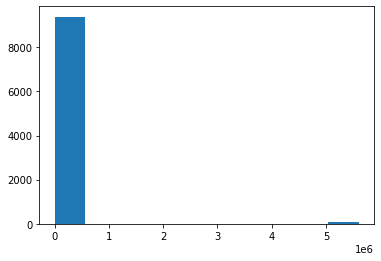

In [9]:
# 히스토그램 확인 -> 데이터의 분포, 중심 경향, 치우침 정도 파악
plt.hist(df['MIXA_PASTEUR_STATE']) 

In [10]:
# 특정 칼럼의 unique 값 확인 -> 결과: 1, 5603841, 0
df['MIXA_PASTEUR_STATE'].unique()

array([1.000000e+00, 5.603841e+06, 0.000000e+00])

In [11]:
# 특정 조건의 값 변경 -> 위에서 0,1인 행만 유지하기 위해 2 이하인 값들에 대해서만 다시 df에 넣는다.
df = df[df.MIXA_PASTEUR_STATE < 2]

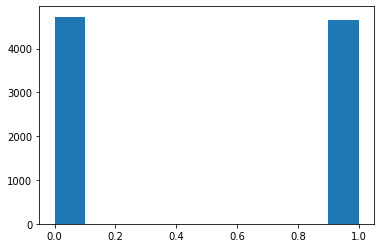

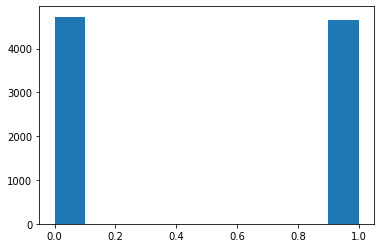

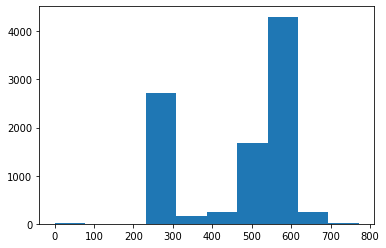

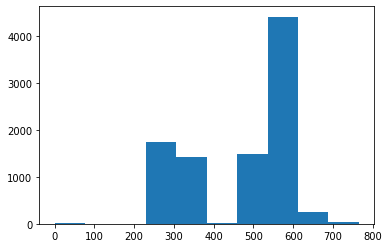

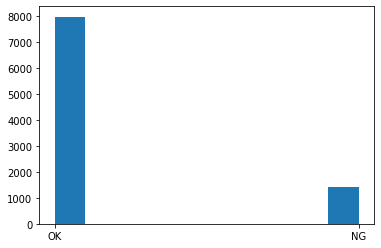

In [12]:
# 다른 모든 칼럼의 히스토그램 확인
plt.hist(df['MIXA_PASTEUR_STATE']) 
plt.show()
plt.hist(df['MIXB_PASTEUR_STATE'])
plt.show()
plt.hist(df['MIXA_PASTEUR_TEMP'])
plt.show()
plt.hist(df['MIXB_PASTEUR_TEMP'])  
plt.show()
plt.hist(df['INSP'])
plt.show()

##### 1-4. 데이터 특성 파악

array([[<AxesSubplot:title={'center':'MIXA_PASTEUR_STATE'}>,
        <AxesSubplot:title={'center':'MIXB_PASTEUR_STATE'}>],
       [<AxesSubplot:title={'center':'MIXA_PASTEUR_TEMP'}>,
        <AxesSubplot:title={'center':'MIXB_PASTEUR_TEMP'}>]], dtype=object)

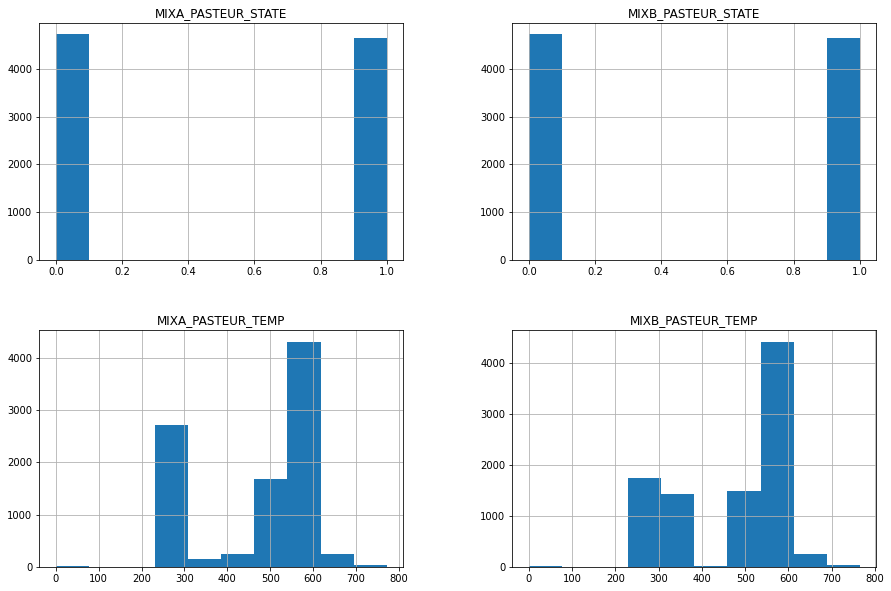

In [13]:
# 요약 통계
df.hist(bins=10, figsize=(15,10))

In [14]:
# 특성 간의 상관관계
df.corr()

,MIXA_PASTEUR_STATE,MIXB_PASTEUR_STATE,MIXA_PASTEUR_TEMP,MIXB_PASTEUR_TEMP
MIXA_PASTEUR_STATE,1.000000,1.000000,0.523328,0.465706
MIXB_PASTEUR_STATE,1.000000,1.000000,0.523328,0.465706
MIXA_PASTEUR_TEMP,0.523328,0.523328,1.000000,0.920102
MIXB_PASTEUR_TEMP,0.465706,0.465706,0.920102,1.000000


<AxesSubplot:>

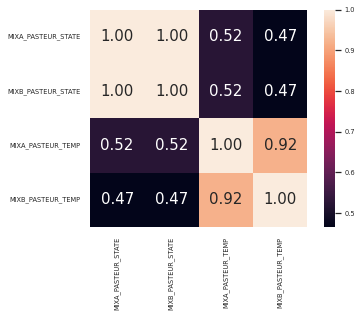

In [15]:
# 히트맵
names = ['MIXA_PASTEUR_STATE', 'MIXB_PASTEUR_STATE', 'MIXA_PASTEUR_TEMP', 'MIXB_PASTEUR_TEMP']
cm = np.corrcoef(df[names].values.T)
sns.set(font_scale=0.6)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
            annot_kws={'size':15}, yticklabels=names, xticklabels=names)

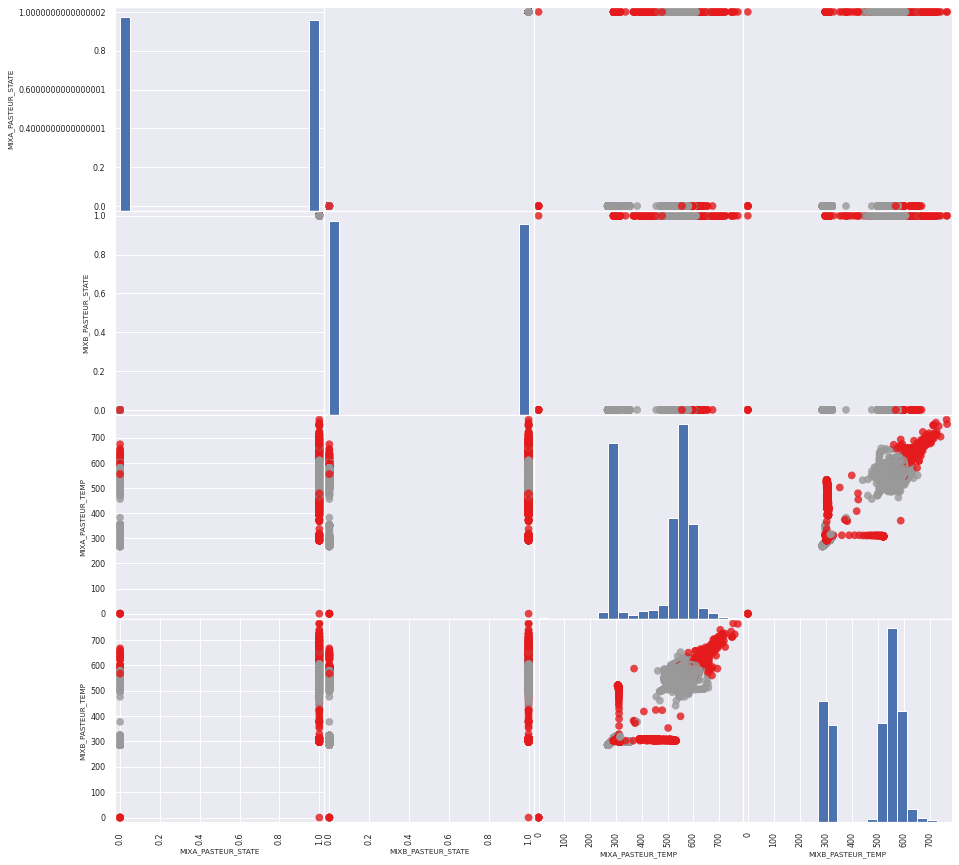

In [16]:
# 산점도 매트릭스
y = df.iloc[:, -1:].values
y = np.where(y=='OK',1,0)
y = y.ravel()
pd.plotting.scatter_matrix(df, c=y, figsize=(15,15), marker='o',
                           hist_kwds={'bins':20}, s=60, alpha=.8, cmap=plt.cm.Set1)
plt.show()

>  ▶ 양품: 회색<br>
>  ▶ 불량: 빨간색<br>
>  <MIXA_PASTEUR_TEMP와 MIXB_PASTEUR_TEMP의 분포> <br>
>  - 특성들 간의 상관관계가 높다.
>  - 양품인 경우: 가운데에 위치.
>  - 불량인 경우: 우측 상단과 ㄴ자 모형으로 패턴 이룸. 

### 2. 모델 학습 및 성능 평가 

##### (공통) 학습/평가 데이터 분리

In [17]:
# 측정 데이터와 레이블(정답) 분리
X = df.iloc[:, 1:5].values
y = df.iloc[:, -1:].values
y = np.where(y =='OK',1,0)
y = y.ravel() # 레이블을 1차원으로 변경함.
print(X.shape, y.shape)

(9383, 4) (9383,)


In [18]:
# 훈련셋과 테스트셋 분리
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=1)

In [19]:
print(len(y_train[y_train == 1]))
print(len(y_train[y_train == 0]))
print(len(y_test[y_test == 1]))
print(len(y_test[y_test == 0]))

5586
982
2382
433


In [20]:
new_y_train = y_train[y_train == 1][:len(y_train[y_train == 0])]
new_y_train = np.concatenate([new_y_train, y_train[y_train == 0]])
new_y_train

array([1, 1, 1, ..., 0, 0, 0])

In [21]:
new_X_train = X_train[y_train == 1][:len(y_train[y_train == 0])]
new_X_train = np.concatenate([new_X_train, X_train[y_train == 0]])
new_X_train

array([[  0.,   0., 526., 584.],
       [  0.,   0., 571., 526.],
       [  0.,   0., 294., 314.],
       ...,
       [  0.,   0., 581., 580.],
       [  1.,   1., 521., 303.],
       [  0.,   0., 558., 573.]])

##### (공통) StandardScalar 적용한 학습/평가 데이터 분리

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# scaler.fit(X)
data_scaled = scaler.fit_transform(X)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_scaled, y, test_size = 0.3, random_state=100)
print(X_train_2, X_test_2, y_train_2, y_test_2)

[[ 1.00802538  1.00802538  0.9609264   0.98815185]
 [ 1.00802538  1.00802538  0.38637009  0.81134398]
 [-0.99203851 -0.99203851  0.74352672  0.85956431]
 ...
 [-0.99203851 -0.99203851  0.44072001  0.76312365]
 [ 1.00802538  1.00802538  0.57271268  0.40950791]
 [ 1.00802538  1.00802538  0.69694107  0.53809546]] [[ 1.00802538  1.00802538  0.44848429  0.74705021]
 [ 1.00802538  1.00802538  0.47954138  0.88367448]
 [ 1.00802538  1.00802538  0.68917679  0.83545415]
 ...
 [-0.99203851 -0.99203851  0.44848429  0.81134398]
 [-0.99203851 -0.99203851 -1.32177029 -1.21390981]
 [-0.99203851 -0.99203851  0.69694107  0.25681021]] [1 1 0 ... 1 1 1] [1 1 1 ... 1 1 1]


##### (공통) 모델 성능 평가 - 1) 분류성능평가지표

> 정량평가: 오차행렬, 정확도, 정밀도, 재현율, F1 score, AUC 살펴보기

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

In [24]:
def get_clf_eval(y_test=None, pred=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0: .4f}, 정밀도: {1: .4f}, 재현율: {2: .4f}, F1: {3: .4f}, AUC:{4: .4f}'.format(accuracy, precision, recall, f1, roc_auc))

> 정성평가: 그래프 살펴보기

In [25]:
import matplotlib.pyplot as plt
def draw_graph(y_test=None, pred=None):
  plt.figure(figsize=(40, 9))
  plt.plot(y_test, 'b', label = 'actual')
  plt.plot(pred, 'r', label = 'prediction')
  plt.legend()
  plt.show()

  # 따로 보기
  # plt.figure(figsize = (30,6)) # Plotting
  # plt.plot(y_test, 'b', label = 'actual')
  # plt.legend()
  # plt.show()
  # plt.figure(figsize=(30, 6))
  # plt.plot(pred, 'r', label = 'prediction')
  # plt.legend()
  # plt.show()

##### (공통) 모델 성능 평가 -2) ROC curve와 case별로 살펴보기 

In [26]:
def get_eval_2(y_test=None, pred=None):
  confusion = confusion_matrix(y_test, pred)
  TN = confusion[0][0]
  FP = confusion[0][1]
  FN = confusion[1][0]
  TP = confusion[1][1]
  print("📌실제 불량일 때 불량으로 판별할 확률\n= P(실제불량)∩P(에측불량)/P(실제불량): {:.4f}".format(TN/(TN+FP)))
  #print("📌실제 불량일 때 양품으로 판별할 확률\n= P(실제불량)∩P(에측양품)/P(실제불량): {:.4f}".format(FP/(TN+FP)))
  #print("📌실제 양품일 때 불량으로 판별할 확률\n= P(실제양품)∩P(에측불량)/P(실제양품): {:.4f}".format(FN/(FN+TP)))
  print("📌실제 양품일 때 양품으로 판별할 확률\n= P(실제양품)∩P(에측양품)/P(실제양품): {:.4f}".format(TP/(FN+TP)))

  roc_auc = roc_auc_score(y_test, pred)
  print('ROC_AUC:{:.4f}'.format(roc_auc))
  return(TN/(TN+FP),TP/(FN+TP),roc_auc)

##### 2-1. 선형 회귀

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline 
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

    
model = LinearRegression().fit(X_train, y_train)
NN = model.predict(X_test).flatten()

In [25]:
NN_prediction = np.array([])
threshold = 0.75
for i in NN:
  if i>= threshold:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))
get_clf_eval(y_test, NN_prediction)
get_eval_2(y_test, NN_prediction)

오차 행렬
[[ 140  293]
 [  49 2333]]
정확도:  0.8785, 정밀도:  0.8884, 재현율:  0.9794, F1:  0.9317, AUC: 0.6514
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.3233
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9794
ROC_AUC:0.6514


(0.3233256351039261, 0.9794290512174643, 0.6513773431606951)

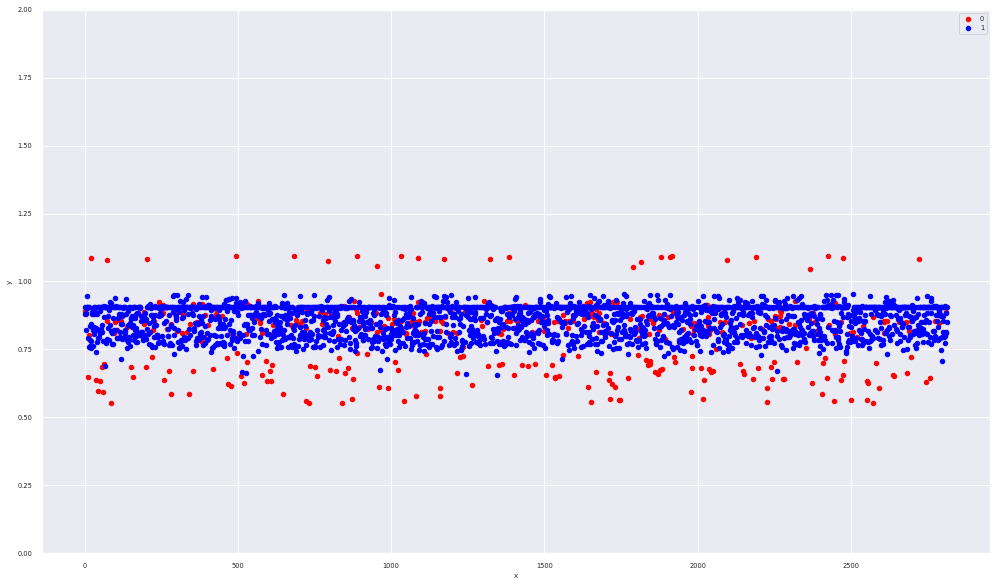

In [26]:
data = pd.DataFrame({'x': range(0, len(X_test)), 
                     'y': NN, 
                     'group':y_test})

fig,ax = plt.subplots(figsize=(17,10))
colors = ['red', 'blue']
for i, (name, group) in enumerate(data.groupby('group')):
  group.plot(ax=ax,
             kind = 'scatter',
             x='x',
             y='y',
             color = colors[i],
             ylim = (0,2),
             label = name)


가설: 만약,  훈련 데이터셋에서 불량, 정상 데이터가 1:1로 들어 있으면 학습이 더 잘 될 것이다.


In [27]:
unique, counts = np.unique(y_train, return_counts = True)
print(counts)


[ 982 5586]


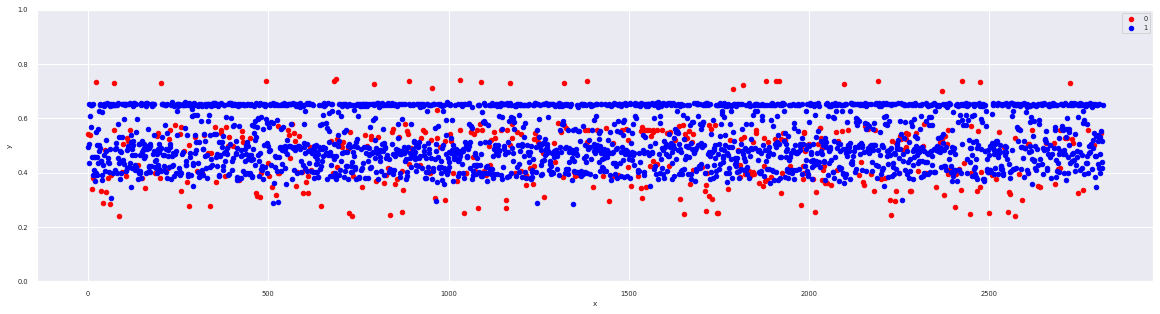

In [28]:
model = LinearRegression().fit(new_X_train, new_y_train)
NN = model.predict(X_test).flatten()
data = pd.DataFrame({'x': range(0, len(X_test)), 
                     'y': NN, 
                     'group':y_test})

fig,ax = plt.subplots(figsize=(20,5))
colors = ['red', 'blue']
for i, (name, group) in enumerate(data.groupby('group')):
  group.plot(ax=ax,
             kind = 'scatter',
             x='x',
             y='y',
             color = colors[i],
             ylim = (0,1),
             label = name)

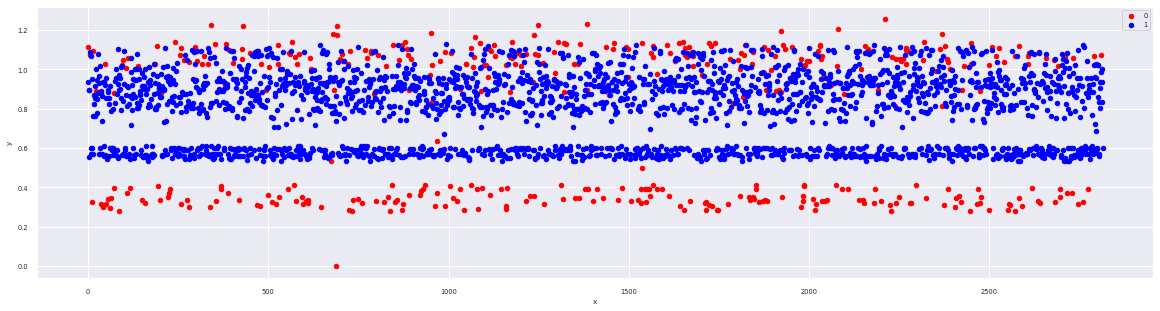

In [29]:
model = LinearRegression(fit_intercept = False, n_jobs=20).fit(X_train, y_train) 
NN = model.predict(X_test).flatten()
data = pd.DataFrame({'x': range(0, len(X_test)), 
                     'y': NN, 
                     'group':y_test})

fig,ax = plt.subplots(figsize=(20,5))
colors = ['red', 'blue']
for i, (name, group) in enumerate(data.groupby('group')):
  group.plot(ax=ax,
             kind = 'scatter',
             x='x',
             y='y',
             color = colors[i],
             label = name)

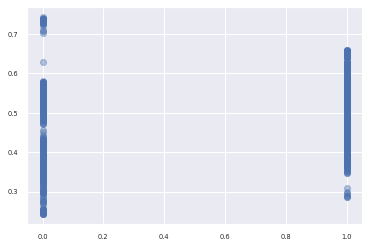

In [30]:
model = LinearRegression().fit(new_X_train, new_y_train)
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.4)

##### 2-2. 로지스틱 회귀

In [31]:
# Scikit-learn 로지스틱 회귀 모델 학습
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train, y_train)
proba = lr.predict_proba(X_test)
print(lr.classes_)
print(proba)
lr_model = lr.predict(X_test).flatten()
get_clf_eval(y_test,lr_model)
get_eval_2(y_test, lr_model)

[0 1]
[[0.11517863 0.88482137]
 [0.11559126 0.88440874]
 [0.09038094 0.90961906]
 ...
 [0.18220977 0.81779023]
 [0.14680224 0.85319776]
 [0.09081707 0.90918293]]
오차 행렬
[[  22  411]
 [   0 2382]]
정확도:  0.8540, 정밀도:  0.8528, 재현율:  1.0000, F1:  0.9206, AUC: 0.5254
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.0508
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 1.0000
ROC_AUC:0.5254


(0.050808314087759814, 1.0, 0.5254041570438799)

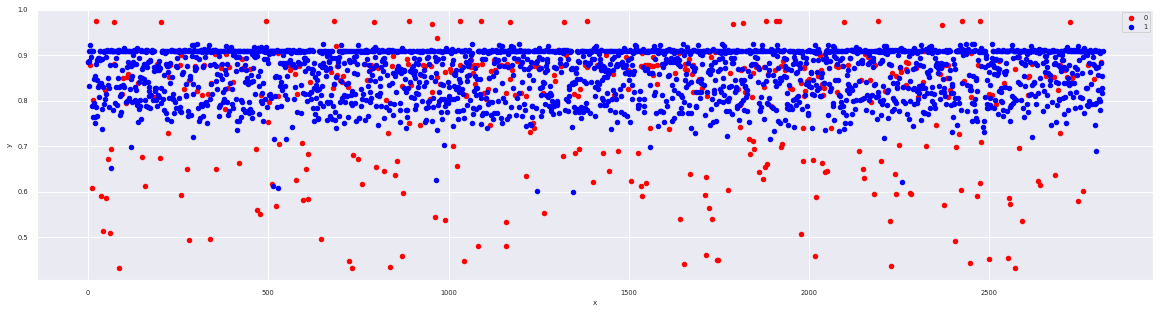

In [32]:
data = pd.DataFrame({'x': range(0, len(X_test)), 
                     'y': np.array(proba).T[1], 
                     'group':y_test})

fig,ax = plt.subplots(figsize=(20,5))
colors = ['red', 'blue']
for i, (name, group) in enumerate(data.groupby('group')):
  group.plot(ax=ax,
             kind = 'scatter',
             x='x',
             y='y',
             color = colors[i],
             label = name,
            #  marker='o', 
            #   s=6, 
        
             )


In [33]:
new_lr = []
for i in range(len(proba)):
  if proba[i][1]>0.8:
    new_lr.append(1)
  else:
    new_lr.append(0)

get_clf_eval(y_test,new_lr)
get_eval_2(y_test, new_lr)

오차 행렬
[[ 150  283]
 [ 441 1941]]
정확도:  0.7428, 정밀도:  0.8728, 재현율:  0.8149, F1:  0.8428, AUC: 0.5806
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.3464
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.8149
ROC_AUC:0.5806


(0.3464203233256351, 0.8148614609571788, 0.580640892141407)

사이킷런의 LogisticRegression 클래스 -> 이진 분류의 경우 시그모이드 함수의 출력이 0.5보다 크면 양성 클래스, 작으면 음성 클래스로 판단

In [34]:
n_samples = 6568
n_classes = 2
n_sample0= 982
n_sample1= 5586
w0= n_samples/(n_classes*n_sample0)
w1= n_samples/(n_classes*n_sample1)
print(w0,w1)

3.344195519348269 0.5878983172216254


In [35]:
# Scikit-learn 로지스틱 회귀 모델 학습
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1',class_weight={0:w0,1:w1},C=0.01, solver='liblinear', max_iter=5000).fit(X_train, y_train)
proba = model.predict_proba(X_test)
lr_model = model.predict(X_test).flatten()
get_clf_eval(y_test,lr_model)
get_eval_2(y_test, lr_model)

오차 행렬
[[ 285  148]
 [ 905 1477]]
정확도:  0.6259, 정밀도:  0.9089, 재현율:  0.6201, F1:  0.7372, AUC: 0.6391
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.6582
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.6201
ROC_AUC:0.6391


(0.6581986143187067, 0.6200671704450041, 0.6391328923818553)

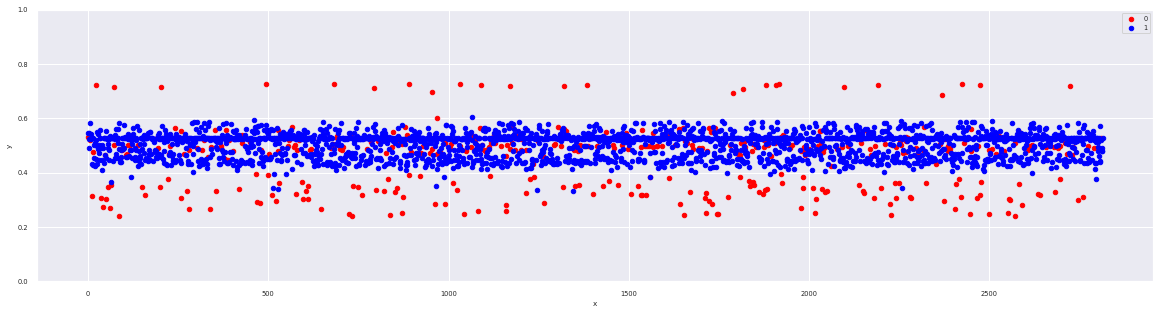

In [36]:
data = pd.DataFrame({'x': range(0, len(X_test)), 
                     'y': np.array(proba).T[1], 
                     'group':y_test})

fig,ax = plt.subplots(figsize=(20,5))
colors = ['red', 'blue']
for i, (name, group) in enumerate(data.groupby('group')):
  group.plot(ax=ax,
             kind = 'scatter',
             x='x',
             y='y',
             color = colors[i],
             label = name,
            #  marker='o', 
            #   s=6, 
             ylim = (0,1)
             )

In [37]:
proba = model.predict_proba(X_test)
new_lr = []
for i in range(len(proba)):
  if proba[i][1]>0.3:
    new_lr.append(1)
  else:
    new_lr.append(0)

get_clf_eval(y_test,new_lr)
get_eval_2(y_test, new_lr)

오차 행렬
[[  39  394]
 [   0 2382]]
정확도:  0.8600, 정밀도:  0.8581, 재현율:  1.0000, F1:  0.9236, AUC: 0.5450
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.0901
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 1.0000
ROC_AUC:0.5450


(0.09006928406466513, 1.0, 0.5450346420323325)

In [38]:
# 하이퍼 파라미터 최적화 진행하기 - 전처리안했을 때
from sklearn.model_selection import GridSearchCV
lr_clf = LogisticRegression().fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

params = {'penalty':['l1', 'l2','elasticnet', None], 
          'C':[0.01, 0.1,1,5,10],
          'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
          'class_weight':[{0:w0,1:w1},{0:1,1:1}],
          'max_iter':[100,500,1000,2000,3000,5000]
          }
grid_clf =  GridSearchCV(lr_clf, param_grid=params, scoring='roc_auc', cv=3)
grid_clf.fit(data_scaled, y) 

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ra

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 5, 10],
                         'class_weight': [{0: 3.344195519348269,
                                           1: 0.5878983172216254},
                                          {0: 1, 1: 1}],
                         'max_iter': [100, 500, 1000, 2000, 3000, 5000],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='roc_auc')

In [39]:
grid_clf.best_params_, grid_clf.best_score_

({'C': 0.01,
  'class_weight': {0: 3.344195519348269, 1: 0.5878983172216254},
  'max_iter': 3000,
  'penalty': None,
  'solver': 'sag'},
 0.5083872862351562)

In [40]:
# 하이퍼 파라미터 최적화 진행하기 - 전처리 했을 때
from sklearn.model_selection import GridSearchCV
lr_clf = LogisticRegression().fit(X_train_2, y_train_2)
lr_preds = lr_clf.predict(X_test_2)

params = {'penalty':['l1', 'l2','elasticnet', None], 
          'C':[0.01, 0.1,1,5,10],
          'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
          'class_weight':[{0:w0,1:w1},{0:1,1:1}],
          'max_iter':[100,500,1000,2000,3000,5000]
          }
grid_clf =  GridSearchCV(lr_clf, param_grid=params, scoring='roc_auc', cv=3)
grid_clf.fit(data_scaled, y) # grid_clf.fit(data_scaled, cancer.target)
# X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_scaled, y, test_size = 0.3, random_state=100)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ra

최적 하이퍼 파라미터:{'C': 0.01, 'class_weight': {0: 3.344195519348269, 1: 0.5878983172216254}, 'max_iter': 500, 'penalty': None, 'solver': 'sag'}, 최적 평균 정확도:0.508


In [41]:
grid_clf.best_params_, grid_clf.best_score_

({'C': 0.01,
  'class_weight': {0: 3.344195519348269, 1: 0.5878983172216254},
  'max_iter': 500,
  'penalty': None,
  'solver': 'sag'},
 0.5083801070948663)

##### 2-3. 의사결정트리

In [42]:
depth = 50 # 변경해보기
dt_clf = DecisionTreeClassifier(max_depth = depth) # 의사결정트리 알고리즘 불러오기
dt_clf = dt_clf.fit(X_train, y_train) # 모델에 데이터 학습시키기
dt_prediction = dt_clf.predict(X_test) # 데이터 예측하기
# 성능평가
get_clf_eval(y_test, dt_prediction)
get_eval_2(y_test, dt_prediction)

오차 행렬
[[ 428    5]
 [   6 2376]]
정확도:  0.9961, 정밀도:  0.9979, 재현율:  0.9975, F1:  0.9977, AUC: 0.9930
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9885
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9975
ROC_AUC:0.9930


(0.9884526558891455, 0.9974811083123426, 0.9929668821007441)

In [43]:
for i in range(len(dt_prediction)):
  if (dt_prediction[i]!=y_test[i]):
    print(X_test[i])
    print(y_test[i], dt_prediction[i])

[  1.   1. 629. 587.]
1 0
[  1.   1. 583. 621.]
1 0
[  1.   1. 611. 609.]
0 1
[  1.   1. 612. 609.]
0 1
[  1.   1. 550. 399.]
0 1
[  1.   1. 623. 582.]
1 0
[  1.   1. 608. 608.]
0 1
[  0.   0. 552. 583.]
0 1
[  0.   0. 548. 577.]
1 0
[  0.   0. 554. 567.]
1 0
[  0.   0. 558. 559.]
1 0


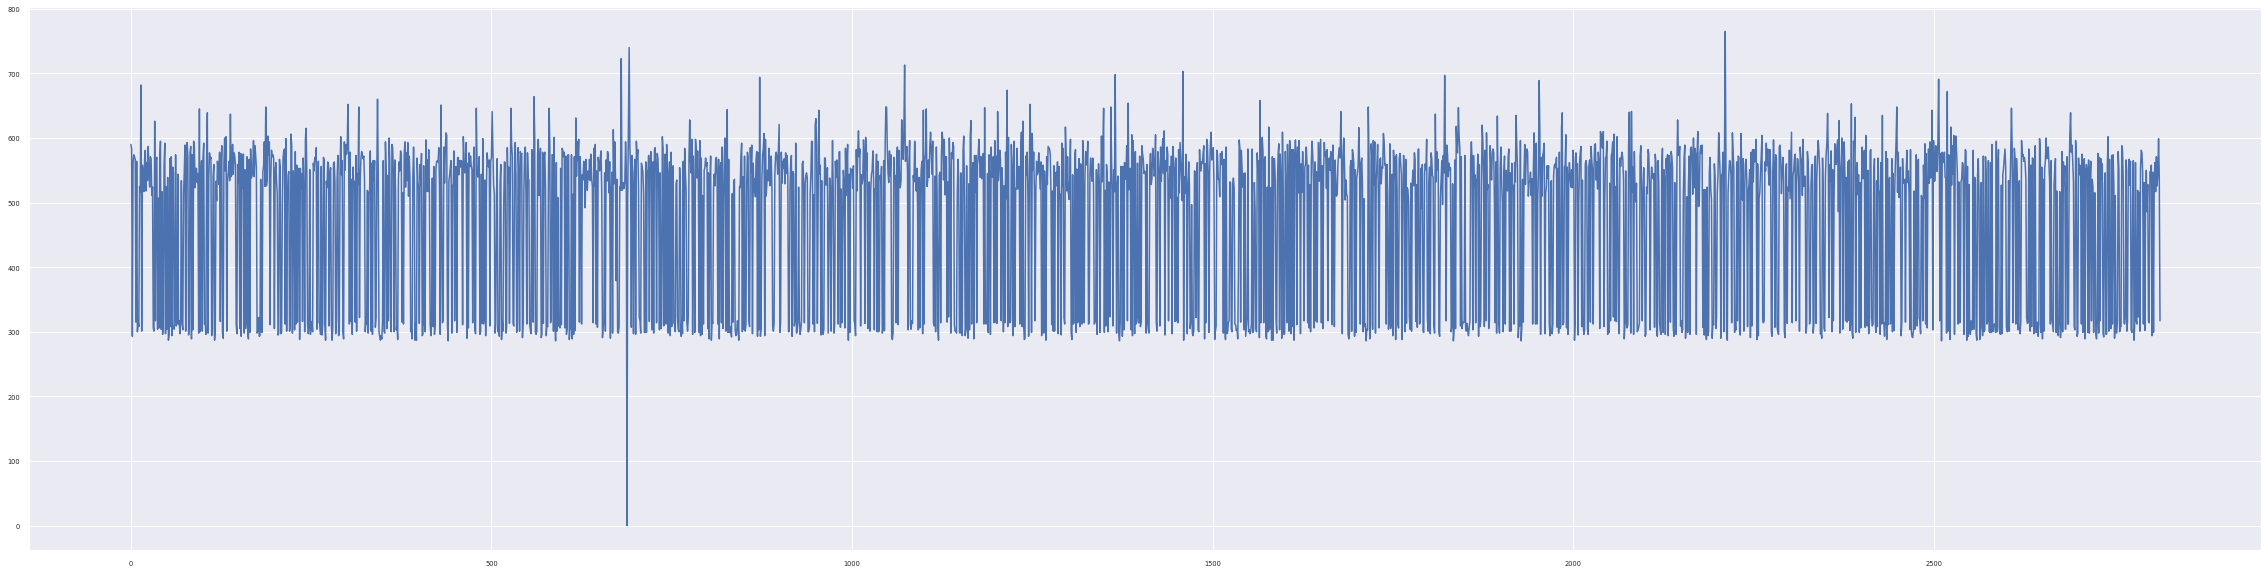

In [44]:
hi = []
plt.figure(figsize=(40,10))
for i in range(len(X_test)):
  hi.append(X_test[i][3])
plt.plot(hi)

In [45]:
Pa_arr = []
Pd_arr = []
Proc_arr = []
for d in range(3,101):
  dt_clf = DecisionTreeClassifier(max_depth = d ) # 의사결정트리 알고리즘 불러오기
  dt_clf = dt_clf.fit(X_train, y_train) # 모델에 데이터 학습시키기
  dt_prediction = dt_clf.predict(X_test) # 데이터 예측하기
  # 성능평가
  print("---------------------depth가",d,"일 때-----------------------")
  get_clf_eval(y_test, dt_prediction)
  Pa, Pd, Proc = get_eval_2(y_test, dt_prediction)
  Pa_arr.append(Pa)
  Pd_arr.append(Pd)
  Proc_arr.append(Proc)

---------------------depth가 3 일 때-----------------------
오차 행렬
[[ 237  196]
 [   1 2381]]
정확도:  0.9300, 정밀도:  0.9239, 재현율:  0.9996, F1:  0.9603, AUC: 0.7735
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.5473
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9996
ROC_AUC:0.7735
---------------------depth가 4 일 때-----------------------
오차 행렬
[[ 238  195]
 [   1 2381]]
정확도:  0.9304, 정밀도:  0.9243, 재현율:  0.9996, F1:  0.9605, AUC: 0.7746
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.5497
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9996
ROC_AUC:0.7746
---------------------depth가 5 일 때-----------------------
오차 행렬
[[ 423   10]
 [  19 2363]]
정확도:  0.9897, 정밀도:  0.9958, 재현율:  0.9920, F1:  0.9939, AUC: 0.9845
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9769
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9920
ROC_AUC:0.9845
---------------------depth가 6 일 때-----------------------
오차 행렬
[[ 424    9]
 [  16 2366]]
정확도:  0.9911, 정밀도:  0.9962, 재현율:  0.9933, F1:  0.9947, AUC

In [46]:
print(Pa_arr)
print(Pd_arr)
print(Proc_arr)

[0.5473441108545035, 0.5496535796766744, 0.976905311778291, 0.9792147806004619, 0.976905311778291, 0.9838337182448037, 0.9861431870669746, 0.9884526558891455, 0.9884526558891455, 0.9907621247113164, 0.9884526558891455, 0.9884526558891455, 0.9884526558891455, 0.9907621247113164, 0.9884526558891455, 0.9884526558891455, 0.9907621247113164, 0.9907621247113164, 0.9907621247113164, 0.9884526558891455, 0.9884526558891455, 0.9884526558891455, 0.9884526558891455, 0.9907621247113164, 0.9884526558891455, 0.9884526558891455, 0.9884526558891455, 0.9884526558891455, 0.9884526558891455, 0.9884526558891455, 0.9884526558891455, 0.9907621247113164, 0.9907621247113164, 0.9907621247113164, 0.9884526558891455, 0.9907621247113164, 0.9907621247113164, 0.9907621247113164, 0.9907621247113164, 0.9907621247113164, 0.9907621247113164, 0.9907621247113164, 0.9884526558891455, 0.9884526558891455, 0.9884526558891455, 0.9907621247113164, 0.9907621247113164, 0.9907621247113164, 0.9884526558891455, 0.9907621247113164, 0

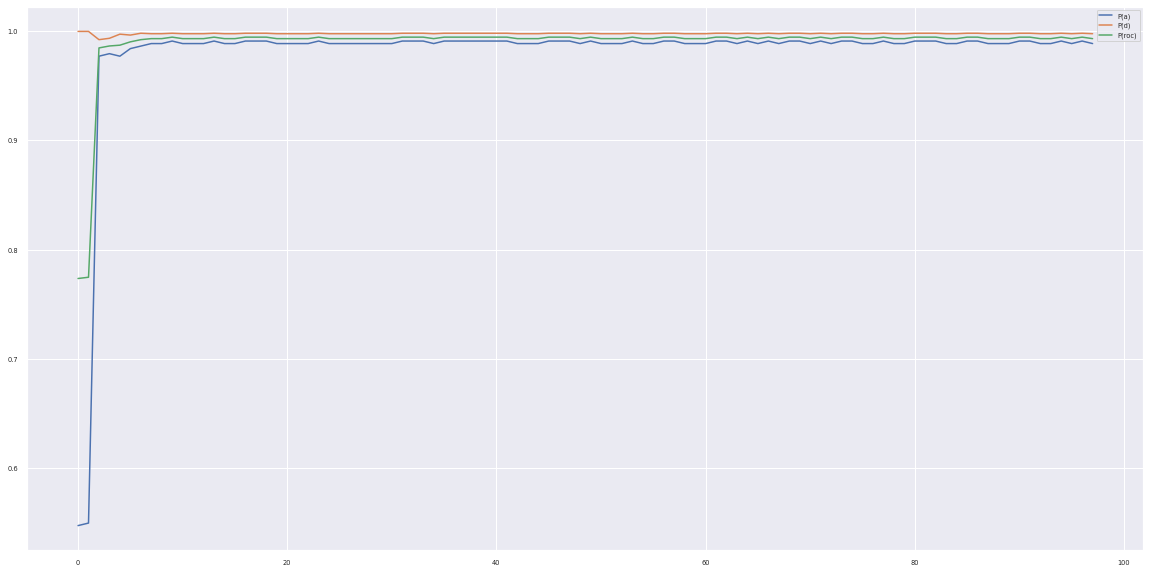

In [47]:
plt.figure(figsize=(20,10))
plt.plot(Pa_arr, label = 'P(a)')
plt.plot(Pd_arr, label = 'P(d)')
plt.plot(Proc_arr, label = 'P(roc)')
plt.legend()

오차 행렬
[[ 423   10]
 [  19 2363]]
정확도:  0.9897, 정밀도:  0.9958, 재현율:  0.9920, F1:  0.9939, AUC: 0.9845
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9769
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9920
ROC_AUC:0.9845


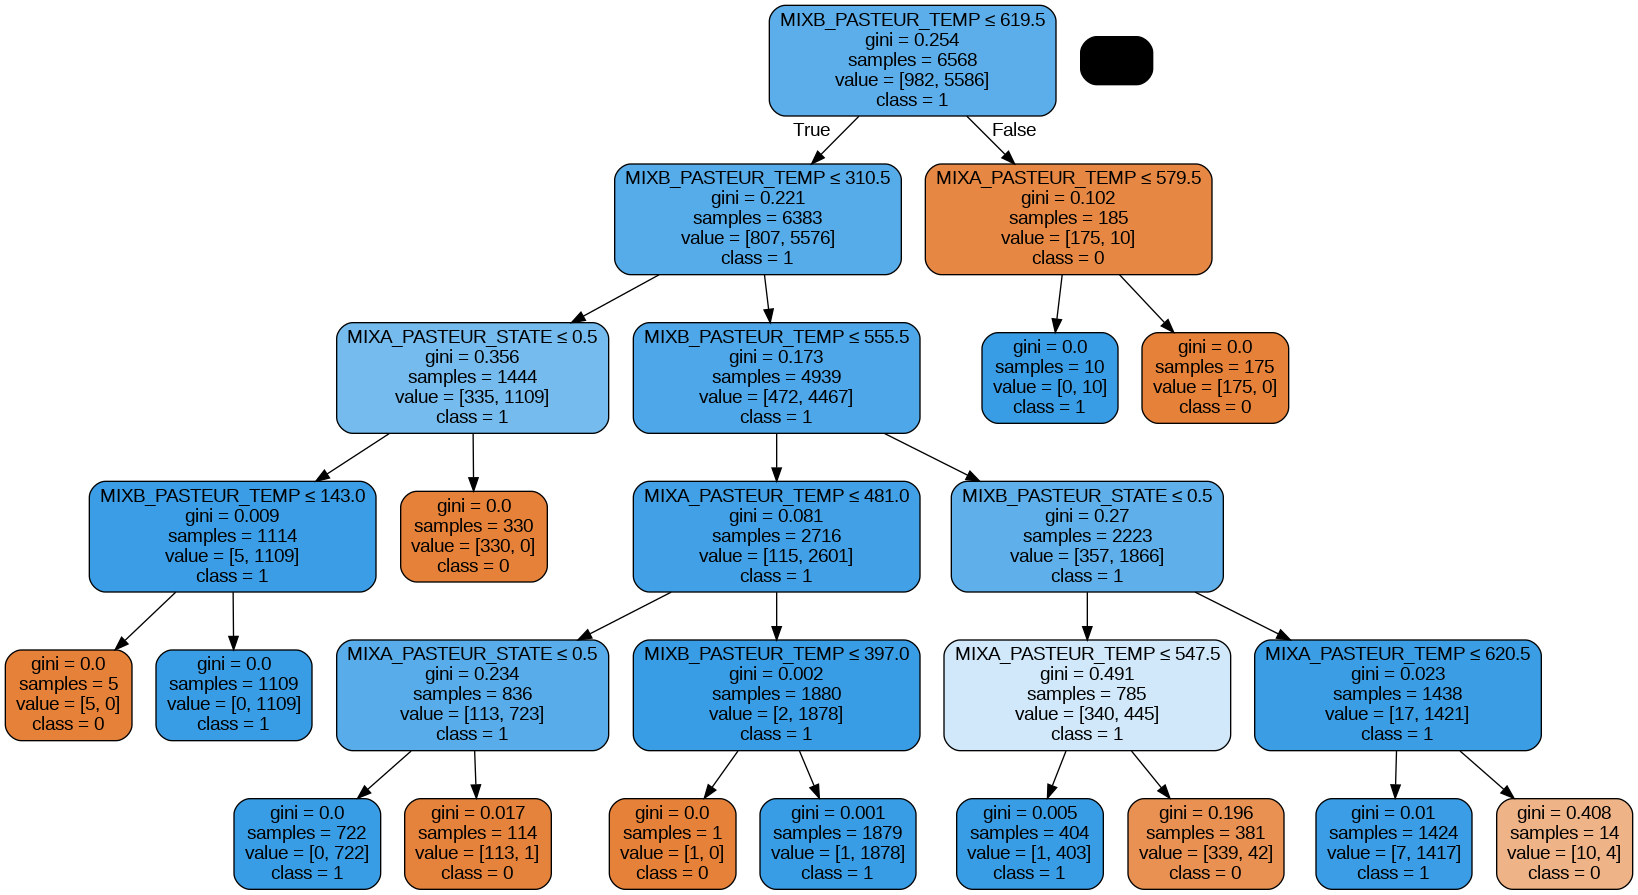

In [48]:
depth = 5 # 변경해보기
dt_clf = DecisionTreeClassifier(max_depth = depth) # 의사결정트리 알고리즘 불러오기
dt_clf = dt_clf.fit(X_train, y_train) # 모델에 데이터 학습시키기
dt_prediction = dt_clf.predict(X_test) # 데이터 예측하기
# 성능평가
get_clf_eval(y_test, dt_prediction)
get_eval_2(y_test, dt_prediction)
# 시각화를 위한 사전 작업
feature_names = df.columns.tolist()
feature_names = feature_names[1:5]
target_name = np.array(['0','1'])
# Graphviz로 시각화하기
dt_dot_data = tree.export_graphviz(dt_clf,
                                   feature_names = feature_names,
                                   class_names = target_name,
                                   filled = True, rounded = True,
                                   special_characters = True)
dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)
Image(dt_graph.create_png())

> 예측 결과 그래프로 보기

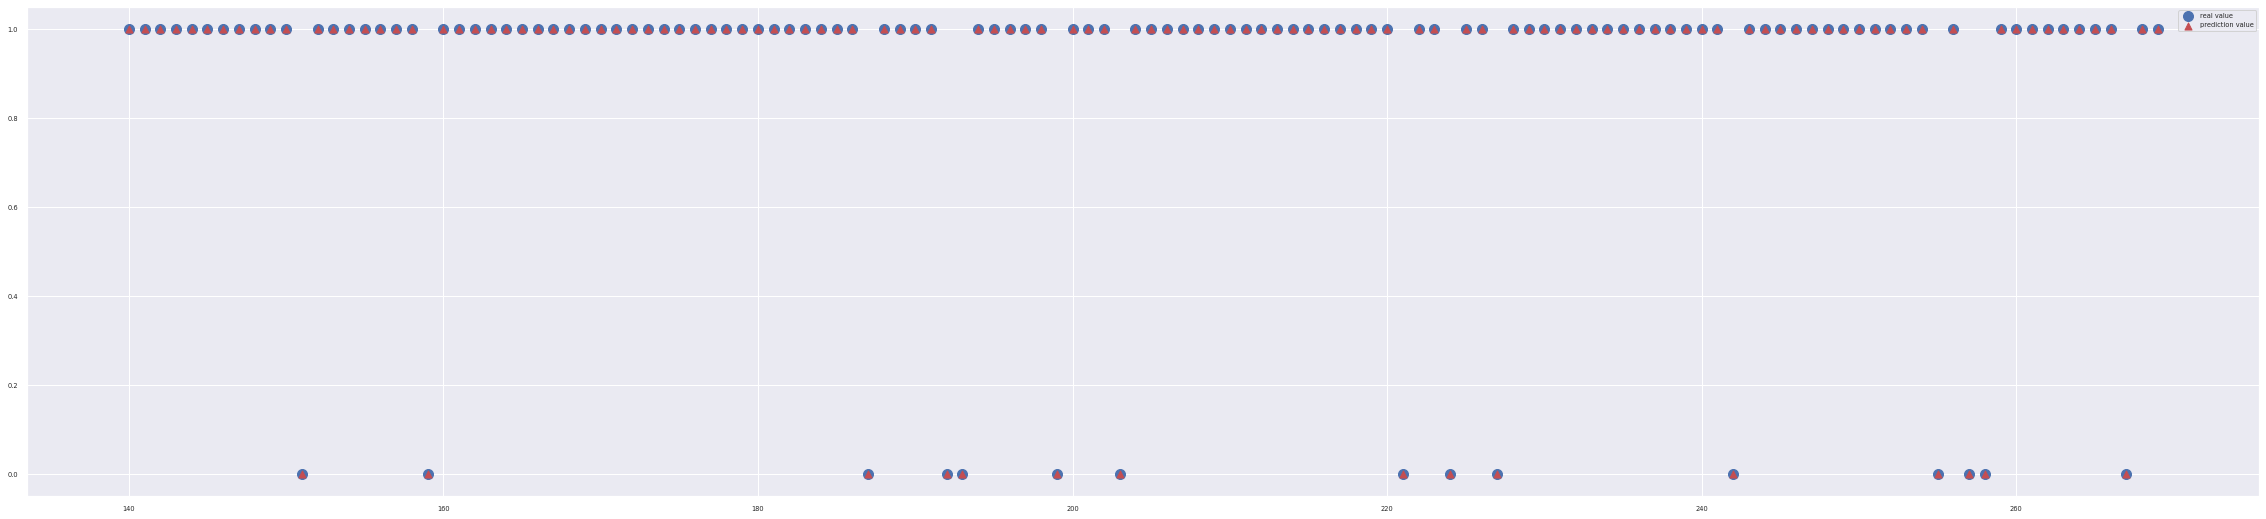

In [49]:
arr = np.array([])
for i in range(len(y_test)):
  if y_test[i]!=dt_prediction[i]:
    arr = np.append(arr, np.array([0]))
  else:
    arr = np.append(arr, np.array([1]))

fig = plt.figure(figsize=(40,9))
arr2 = np.arange(len(y_test))
plt.scatter(arr2[140:270],y_test[140:270],c='b',s=100, label="real value")
plt.scatter(arr2[140:270],dt_prediction[140:270],c='r',marker='^', s=50, label="prediction value")
plt.grid(True)
plt.legend()
    

##### 2-4. 인공신경망

In [50]:
def draw_loss(history):
  history_dict = history.history
  loss = history_dict['loss']
  history_dict.keys()
  # val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'b', label='Training loss')  # ‘bo’는 파란색 점을 의미합니다.
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

Epoch 1/10
13/13 [==============================] - 1s 3ms/step - loss: 1.9046 - acc: 0.7231
Epoch 2/10
13/13 [==============================] - 0s 3ms/step - loss: 0.3744 - acc: 0.9006
Epoch 3/10
13/13 [==============================] - 0s 3ms/step - loss: 0.3794 - acc: 0.9013
Epoch 4/10
13/13 [==============================] - 0s 3ms/step - loss: 0.4240 - acc: 0.8991
Epoch 5/10
13/13 [==============================] - 0s 3ms/step - loss: 0.3904 - acc: 0.9012
Epoch 6/10
13/13 [==============================] - 0s 3ms/step - loss: 0.4018 - acc: 0.9013
Epoch 7/10
13/13 [==============================] - 0s 3ms/step - loss: 0.3862 - acc: 0.9019
Epoch 8/10
13/13 [==============================] - 0s 3ms/step - loss: 0.4288 - acc: 0.8968
Epoch 9/10
13/13 [==============================] - 0s 3ms/step - loss: 0.3843 - acc: 0.9016
Epoch 10/10
88/88 [==============================] - 0s 2ms/step
오차 행렬
[[ 164  269]
 [  15 2367]]
정확도:  0.8991, 정밀도:  0.8980, 재현율:  0.9937, F1:  0.9434, AUC: 0.686

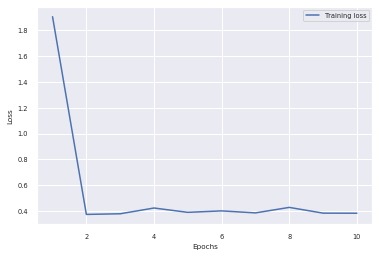

In [51]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=512)

NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.5:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))

get_clf_eval(y_test, NN_prediction)
draw_loss(history)

Epoch 1/15
13/13 [==============================] - 1s 3ms/step - loss: 41.3056 - acc: 0.8512
Epoch 2/15
13/13 [==============================] - 0s 2ms/step - loss: 31.4734 - acc: 0.8512
Epoch 3/15
13/13 [==============================] - 0s 2ms/step - loss: 23.0570 - acc: 0.8512
Epoch 4/15
13/13 [==============================] - 0s 2ms/step - loss: 15.4661 - acc: 0.8512
Epoch 5/15
13/13 [==============================] - 0s 2ms/step - loss: 9.0535 - acc: 0.8512
Epoch 6/15
13/13 [==============================] - 0s 2ms/step - loss: 3.7755 - acc: 0.8514
Epoch 7/15
13/13 [==============================] - 0s 2ms/step - loss: 0.9457 - acc: 0.6288
Epoch 8/15
13/13 [==============================] - 0s 2ms/step - loss: 0.7451 - acc: 0.8467
Epoch 9/15
13/13 [==============================] - 0s 2ms/step - loss: 0.5429 - acc: 0.8523
Epoch 10/15
13/13 [==============================] - 0s 2ms/step - loss: 0.4864 - acc: 0.8541
Epoch 11/15
13/13 [==============================] - 0s 2ms/step 

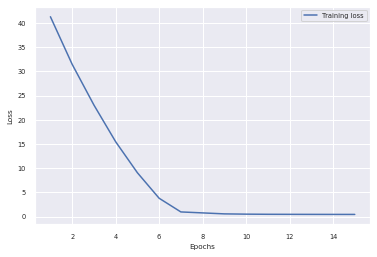

In [52]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, batch_size=512)

NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.5:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))

get_clf_eval(y_test, NN_prediction)
draw_loss(history)

Epoch 1/15
13/13 [==============================] - 1s 2ms/step - loss: 83.2095 - acc: 0.1488
Epoch 2/15
13/13 [==============================] - 0s 2ms/step - loss: 43.5568 - acc: 0.1475
Epoch 3/15
13/13 [==============================] - 0s 2ms/step - loss: 14.5879 - acc: 0.1786
Epoch 4/15
13/13 [==============================] - 0s 2ms/step - loss: 3.2153 - acc: 0.7782
Epoch 5/15
13/13 [==============================] - 0s 2ms/step - loss: 3.4265 - acc: 0.8621
Epoch 6/15
13/13 [==============================] - 0s 3ms/step - loss: 2.0782 - acc: 0.6717
Epoch 7/15
13/13 [==============================] - 0s 2ms/step - loss: 1.7507 - acc: 0.7262
Epoch 8/15
13/13 [==============================] - 0s 2ms/step - loss: 1.5178 - acc: 0.7756
Epoch 9/15
13/13 [==============================] - 0s 2ms/step - loss: 1.3063 - acc: 0.8071
Epoch 10/15
13/13 [==============================] - 0s 2ms/step - loss: 1.0667 - acc: 0.8016
Epoch 11/15
13/13 [==============================] - 0s 2ms/step -

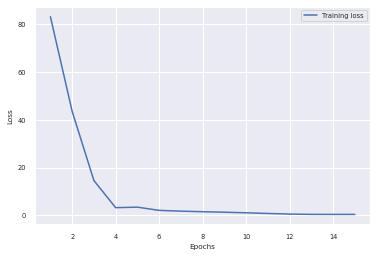

In [53]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, batch_size=512)

NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.5:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))

get_clf_eval(y_test, NN_prediction)
draw_loss(history)

Epoch 1/15
13/13 [==============================] - 1s 2ms/step - loss: 290.0888 - acc: 0.1488
Epoch 2/15
13/13 [==============================] - 0s 2ms/step - loss: 161.3840 - acc: 0.1486
Epoch 3/15
13/13 [==============================] - 0s 2ms/step - loss: 44.1343 - acc: 0.2380
Epoch 4/15
13/13 [==============================] - 0s 2ms/step - loss: 7.2558 - acc: 0.8505
Epoch 5/15
13/13 [==============================] - 0s 2ms/step - loss: 9.1465 - acc: 0.8505
Epoch 6/15
13/13 [==============================] - 0s 2ms/step - loss: 6.8353 - acc: 0.8505
Epoch 7/15
13/13 [==============================] - 0s 2ms/step - loss: 3.4577 - acc: 0.8534
Epoch 8/15
13/13 [==============================] - 0s 2ms/step - loss: 1.0514 - acc: 0.7113
Epoch 9/15
13/13 [==============================] - 0s 2ms/step - loss: 0.8179 - acc: 0.8554
Epoch 10/15
13/13 [==============================] - 0s 2ms/step - loss: 0.6767 - acc: 0.7444
Epoch 11/15
13/13 [==============================] - 0s 2ms/step

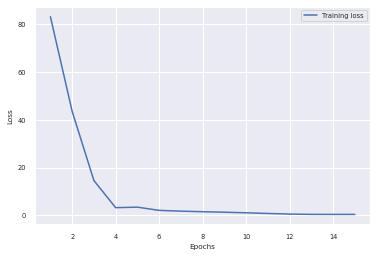

In [54]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(4, )))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer='Adamax',
             loss='binary_crossentropy',
             metrics=['acc'])
model.fit(X_train, y_train, epochs=15, batch_size=512)

NN = model.predict(X_test).flatten()

NN_prediction = np.array([])
for i in NN:
  if i>=0.5:
    NN_prediction = np.append(NN_prediction, np.array([1]))
  else:
    NN_prediction = np.append(NN_prediction, np.array([0]))

get_clf_eval(y_test, NN_prediction)
draw_loss(history)

##### 2-5. 랜덤포레스트

In [55]:
from sklearn.ensemble import RandomForestClassifier
fr_clf = RandomForestClassifier(n_estimators=32, max_depth=15,random_state=29)
fr_clf = fr_clf.fit(X_train, y_train)
fr_prediction = fr_clf.predict(X_test)
# 성능평가
get_clf_eval(y_test, fr_prediction)
get_eval_2(y_test, fr_prediction)

오차 행렬
[[ 430    3]
 [   4 2378]]
정확도:  0.9975, 정밀도:  0.9987, 재현율:  0.9983, F1:  0.9985, AUC: 0.9957
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9931
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9983
ROC_AUC:0.9957


(0.9930715935334873, 0.998320738874895, 0.9956961662041912)

칼럼별 중요도 보기

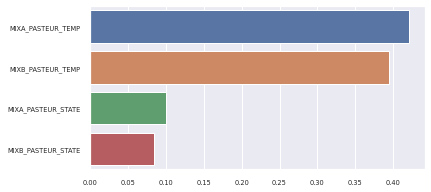

In [56]:
fr_importances_values = fr_clf.feature_importances_
names = ['MIXA_PASTEUR_STATE', 'MIXB_PASTEUR_STATE', 'MIXA_PASTEUR_TEMP', 'MIXB_PASTEUR_TEMP']
fr_importances = pd.Series(fr_importances_values, index=names)
fr_top = fr_importances.sort_values(ascending=False)
plt.figure(figsize=(6, 3))
sns.barplot(x=fr_top, y=fr_top.index)
plt.show()
# 하지만 중요 칼럼에 대해서만 학습을 시키기에는 현재 칼럼 수가 너무 적다. 

In [57]:
for i in range(len(fr_prediction)):
  if (fr_prediction[i]!=y_test[i]):
    print(X_test[i])
    print(y_test[i], fr_prediction[i])

[  1.   1. 629. 587.]
1 0
[  1.   1. 627. 578.]
1 0
[  1.   1. 611. 609.]
0 1
[  1.   1. 550. 399.]
0 1
[  1.   1. 608. 608.]
0 1
[  0.   0. 554. 567.]
1 0
[  0.   0. 558. 559.]
1 0


In [58]:
from sklearn.ensemble import RandomForestClassifier
Pa_arr = []
Pd_arr = []
Proc_arr = []
for d in range(2,100):
  fr_clf = RandomForestClassifier(n_estimators=32, max_depth=15,random_state=d)
  fr_clf = fr_clf.fit(X_train, y_train)
  fr_prediction = fr_clf.predict(X_test)
  # 성능평가
  print("---------------------ramdom_state가",d,"일 때-----------------------")
  get_clf_eval(y_test, fr_prediction)
  Pa, Pd, Proc = get_eval_2(y_test, fr_prediction)
  Pa_arr.append(Pa)
  Pd_arr.append(Pd)
  Proc_arr.append(Proc)

---------------------ramdom_state가 2 일 때-----------------------
오차 행렬
[[ 427    6]
 [   5 2377]]
정확도:  0.9961, 정밀도:  0.9975, 재현율:  0.9979, F1:  0.9977, AUC: 0.9920
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9861
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9979
ROC_AUC:0.9920
---------------------ramdom_state가 3 일 때-----------------------
오차 행렬
[[ 429    4]
 [   5 2377]]
정확도:  0.9968, 정밀도:  0.9983, 재현율:  0.9979, F1:  0.9981, AUC: 0.9943
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9908
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9979
ROC_AUC:0.9943
---------------------ramdom_state가 4 일 때-----------------------
오차 행렬
[[ 426    7]
 [   3 2379]]
정확도:  0.9964, 정밀도:  0.9971, 재현율:  0.9987, F1:  0.9979, AUC: 0.9913
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9838
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9987
ROC_AUC:0.9913
---------------------ramdom_state가 5 일 때-----------------------
오차 행렬
[[ 427    6]
 [   4 2378]]
정확도:  0.9964, 정밀도:  0.9975, 재현

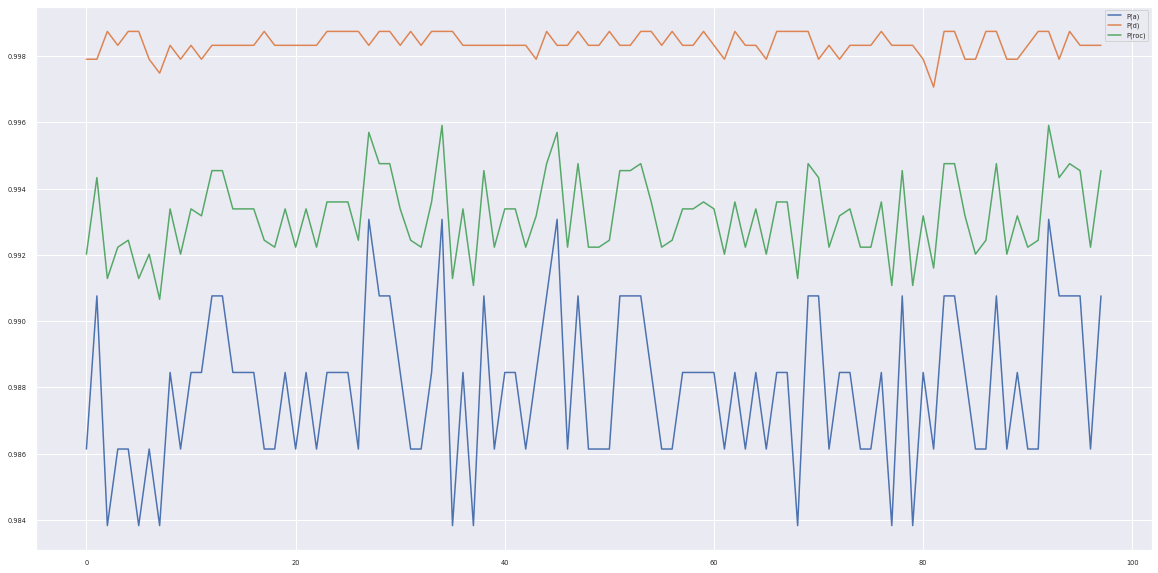

In [59]:
plt.figure(figsize=(20,10))
plt.plot(Pa_arr, label = 'P(a)')
plt.plot(Pd_arr, label = 'P(d)')
plt.plot(Proc_arr, label = 'P(roc)')
plt.legend()

##### 2-6. Gradient Boosting

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state = 0, n_estimators= 1000, learning_rate=0.09, subsample= 0.9,max_depth=5)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
get_clf_eval(y_test, gb_pred)
get_eval_2(y_test, gb_pred)

오차 행렬
[[ 425    8]
 [   6 2376]]
정확도:  0.9950, 정밀도:  0.9966, 재현율:  0.9975, F1:  0.9971, AUC: 0.9895
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9815
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9975
ROC_AUC:0.9895


(0.9815242494226328, 0.9974811083123426, 0.9895026788674878)

In [61]:
from sklearn.ensemble import GradientBoostingClassifier
Pa_arr = []
Pd_arr = []
Proc_arr = []
iteration = np.arange(0.01,0.12,0.02)
for d in iteration:
  gb_clf = GradientBoostingClassifier(random_state = 0,learning_rate=d, n_estimators= 1000,max_depth=20)
  gb_clf.fit(X_train, y_train)
  gb_pred = gb_clf.predict(X_test)
  print("---------------------max_depth가",d,"일 때-----------------------")
  get_clf_eval(y_test, gb_pred)
  Pa, Pd, Proc = get_eval_2(y_test, gb_pred)
  Pa_arr.append(Pa)
  Pd_arr.append(Pd)
  Proc_arr.append(Proc)

---------------------max_depth가 0.01 일 때-----------------------
오차 행렬
[[ 428    5]
 [   5 2377]]
정확도:  0.9964, 정밀도:  0.9979, 재현율:  0.9979, F1:  0.9979, AUC: 0.9932
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9885
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9979
ROC_AUC:0.9932
---------------------max_depth가 0.03 일 때-----------------------
오차 행렬
[[ 428    5]
 [   5 2377]]
정확도:  0.9964, 정밀도:  0.9979, 재현율:  0.9979, F1:  0.9979, AUC: 0.9932
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9885
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9979
ROC_AUC:0.9932
---------------------max_depth가 0.049999999999999996 일 때-----------------------
오차 행렬
[[ 429    4]
 [   5 2377]]
정확도:  0.9968, 정밀도:  0.9983, 재현율:  0.9979, F1:  0.9981, AUC: 0.9943
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9908
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9979
ROC_AUC:0.9943
---------------------max_depth가 0.06999999999999999 일 때-----------------------
오차 행렬
[[ 429    4]
 [   5 2377]]

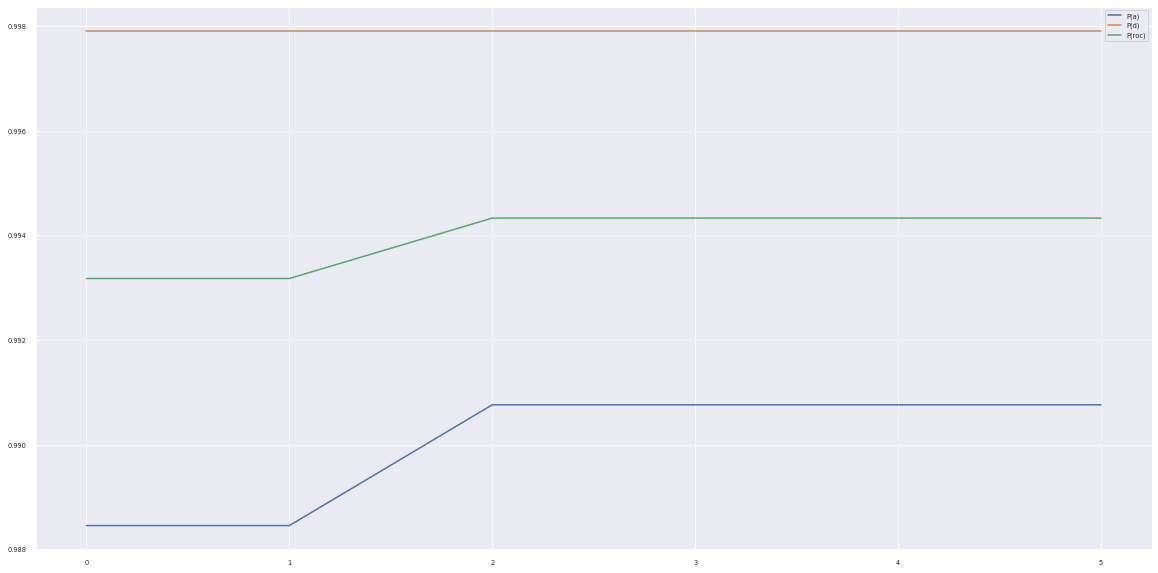

In [62]:
plt.figure(figsize=(20,10))
plt.plot(Pa_arr, label = 'P(a)')
plt.plot(Pd_arr, label = 'P(d)')
plt.plot(Proc_arr, label = 'P(roc)')
plt.legend()

##### 2-7. SVM machine

In [27]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
Pa_arr = []
Pd_arr = []
Proc_arr = []
#iteration = np.arange(0.01,0.12,0.02)
#for d in iteration:
for i in range(2,15):
  polynomial_svm_clf = Pipeline([
      ("poly_features", PolynomialFeatures(degree=i)),
      ("scaler", StandardScaler()),
      ("svm_clf", LinearSVC(C=10, loss="hinge"))
  ])
  polynomial_svm_clf.fit(X_train, y_train)
  sv_pred = polynomial_svm_clf.predict(X_test)
  print("---------------------degree가",i,"일 때-----------------------")
  get_clf_eval(y_test, sv_pred)
  Pa, Pd, Proc = get_eval_2(y_test, sv_pred)
  Pa_arr.append(Pa)
  Pd_arr.append(Pd)
  Proc_arr.append(Proc)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 2 일 때-----------------------
오차 행렬
[[ 393   40]
 [  18 2364]]
정확도:  0.9794, 정밀도:  0.9834, 재현율:  0.9924, F1:  0.9879, AUC: 0.9500
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9076
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9924
ROC_AUC:0.9500


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 3 일 때-----------------------
오차 행렬
[[ 399   34]
 [  17 2365]]
정확도:  0.9819, 정밀도:  0.9858, 재현율:  0.9929, F1:  0.9893, AUC: 0.9572
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9215
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9929
ROC_AUC:0.9572


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 4 일 때-----------------------
오차 행렬
[[ 397   36]
 [   3 2379]]
정확도:  0.9861, 정밀도:  0.9851, 재현율:  0.9987, F1:  0.9919, AUC: 0.9578
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9169
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9987
ROC_AUC:0.9578


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 5 일 때-----------------------
오차 행렬
[[ 400   33]
 [   1 2381]]
정확도:  0.9879, 정밀도:  0.9863, 재현율:  0.9996, F1:  0.9929, AUC: 0.9617
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9238
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9996
ROC_AUC:0.9617


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 6 일 때-----------------------
오차 행렬
[[ 426    7]
 [  11 2371]]
정확도:  0.9936, 정밀도:  0.9971, 재현율:  0.9954, F1:  0.9962, AUC: 0.9896
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9838
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9954
ROC_AUC:0.9896


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 7 일 때-----------------------
오차 행렬
[[ 422   11]
 [  12 2370]]
정확도:  0.9918, 정밀도:  0.9954, 재현율:  0.9950, F1:  0.9952, AUC: 0.9848
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9746
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9950
ROC_AUC:0.9848


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 8 일 때-----------------------
오차 행렬
[[ 428    5]
 [  16 2366]]
정확도:  0.9925, 정밀도:  0.9979, 재현율:  0.9933, F1:  0.9956, AUC: 0.9909
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9885
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9933
ROC_AUC:0.9909


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 9 일 때-----------------------
오차 행렬
[[ 424    9]
 [  45 2337]]
정확도:  0.9808, 정밀도:  0.9962, 재현율:  0.9811, F1:  0.9886, AUC: 0.9802
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9792
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9811
ROC_AUC:0.9802


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 10 일 때-----------------------
오차 행렬
[[ 400   33]
 [   6 2376]]
정확도:  0.9861, 정밀도:  0.9863, 재현율:  0.9975, F1:  0.9919, AUC: 0.9606
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9238
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9975
ROC_AUC:0.9606


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 11 일 때-----------------------
오차 행렬
[[ 415   18]
 [   2 2380]]
정확도:  0.9929, 정밀도:  0.9925, 재현율:  0.9992, F1:  0.9958, AUC: 0.9788
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9584
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9992
ROC_AUC:0.9788


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 12 일 때-----------------------
오차 행렬
[[ 421   12]
 [   3 2379]]
정확도:  0.9947, 정밀도:  0.9950, 재현율:  0.9987, F1:  0.9969, AUC: 0.9855
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9723
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9987
ROC_AUC:0.9855


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---------------------degree가 13 일 때-----------------------
오차 행렬
[[ 418   15]
 [   2 2380]]
정확도:  0.9940, 정밀도:  0.9937, 재현율:  0.9992, F1:  0.9964, AUC: 0.9823
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9654
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9992
ROC_AUC:0.9823
---------------------degree가 14 일 때-----------------------
오차 행렬
[[ 420   13]
 [   3 2379]]
정확도:  0.9943, 정밀도:  0.9946, 재현율:  0.9987, F1:  0.9966, AUC: 0.9844
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9700
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9987
ROC_AUC:0.9844


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


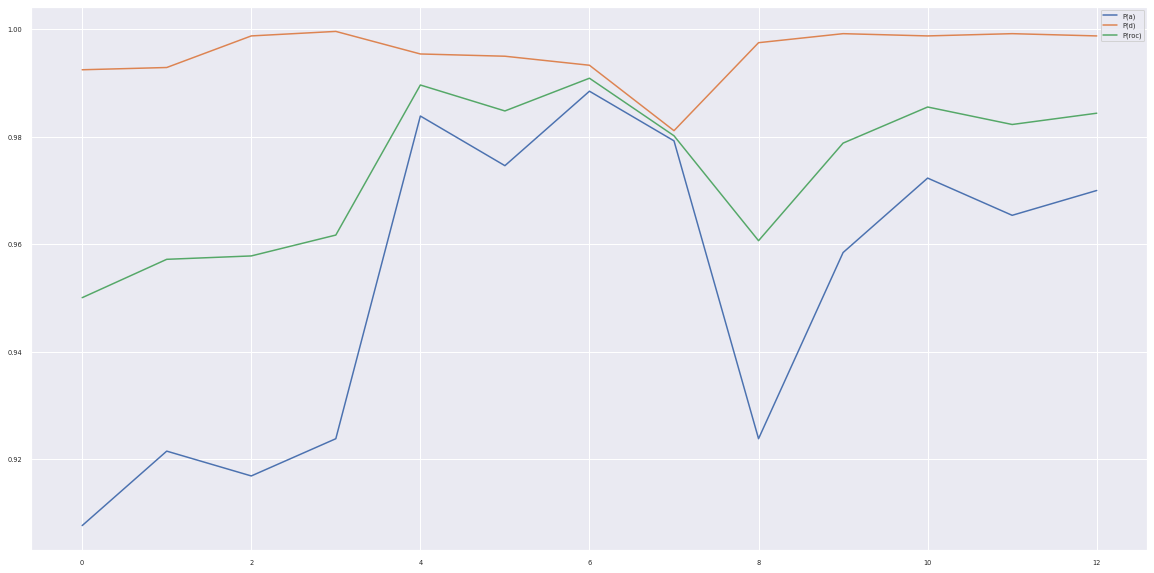

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(figsize=(20,10))
plt.plot(Pa_arr, label = 'P(a)')
plt.plot(Pd_arr, label = 'P(d)')
plt.plot(Proc_arr, label = 'P(roc)')
plt.legend()

In [29]:
# 선형분리
from sklearn import svm
sv = svm.SVC(kernel = 'linear', C=10, max_iter = 10000)
result = sv.fit(X_train, y_train)
sv_pred = sv.predict(X_test)
get_clf_eval(y_test, sv_pred)
get_eval_2(y_test, sv_pred)

오차 행렬
[[ 189  244]
 [ 798 1584]]
정확도:  0.6298, 정밀도:  0.8665, 재현율:  0.6650, F1:  0.7525, AUC: 0.5507
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.4365
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.6650
ROC_AUC:0.5507


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


(0.43648960739030024, 0.6649874055415617, 0.5507385064659309)

In [30]:
# 선형분리
from sklearn import svm
sv = svm.SVC(kernel = 'linear', C=10, max_iter = 10000)
result = sv.fit(X_train, y_train)
sv_pred = sv.predict(X_test)
get_clf_eval(y_test, sv_pred)
get_eval_2(y_test, sv_pred)

오차 행렬
[[ 189  244]
 [ 798 1584]]
정확도:  0.6298, 정밀도:  0.8665, 재현율:  0.6650, F1:  0.7525, AUC: 0.5507
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.4365
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.6650
ROC_AUC:0.5507


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


(0.43648960739030024, 0.6649874055415617, 0.5507385064659309)

In [31]:
# 그래프 그려보기기
plt.show()

In [32]:
# 비선형분리
from sklearn import svm
sv = svm.SVC(kernel = 'rbf', gamma = 'auto', C=10, max_iter = 10000)
result = sv.fit(X_train, y_train)
sv_pred = sv.predict(X_test)
get_clf_eval(y_test, sv_pred)
get_eval_2(y_test, sv_pred)
# 그래프 그려보기

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


오차 행렬
[[ 377   56]
 [   6 2376]]
정확도:  0.9780, 정밀도:  0.9770, 재현율:  0.9975, F1:  0.9871, AUC: 0.9341
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.8707
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9975
ROC_AUC:0.9341


(0.8706697459584296, 0.9974811083123426, 0.9340754271353862)

In [33]:
# 비선형분리
from sklearn import svm
sv = svm.SVC(kernel = 'rbf', gamma = 'auto', C=10, max_iter = 10000)
result = sv.fit(X_train_2, y_train_2)
sv_pred = sv.predict(X_test_2)
get_clf_eval(y_test_2, sv_pred)
get_eval_2(y_test_2, sv_pred)
# 그래프 그려보기

오차 행렬
[[ 432   21]
 [  13 2349]]
정확도:  0.9879, 정밀도:  0.9911, 재현율:  0.9945, F1:  0.9928, AUC: 0.9741
📌실제 불량일 때 불량으로 판별할 확률
= P(실제불량)∩P(에측불량)/P(실제불량): 0.9536
📌실제 양품일 때 양품으로 판별할 확률
= P(실제양품)∩P(에측양품)/P(실제양품): 0.9945
ROC_AUC:0.9741


(0.9536423841059603, 0.9944961896697714, 0.9740692868878658)

In [34]:
import sklearn.svm as svm
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, cross_validate

# SVM, kernel = 'linear'로 선형분리 진행
svm_clf =svm.SVC(kernel = 'rbf', max_iter = 10000)

# 교차검증

scores = cross_val_score(svm_clf, X_train, y_train, cv = 5)
scores

pd.DataFrame(cross_validate(svm_clf, X_train, y_train, cv =5))

print('교차검증 평균: ', scores.mean())

# X_train_2, X_test_2, y_train_2, y_test_2

교차검증 평균:  0.9089529711664527
